In [2]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

In [3]:
%matplotlib notebook

# Select data

## IGNORE THESE:
##### V1:  JC076-20190501, JC083-20190510
    - if rfs only, ignore: JC083-20190510, JC083-20190511, 
    
    - if blobs & rfs only, ignore: JC083_20190510, JC083-20190511
    
    - if ALL stimuli, ignore: JC083-20190507, JC083-20190510, 
    
#### Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if rfs only, ignore: JC078-20190504, JC078-2019513, 
                           JC083-20190512

    - if blobs & rfs: ignore: JC078-20190426, JC078-2019513
                              JC083-20190512
                              
    - if ALL stimuli, ignore: JC078-20190430, JC078-20190426, JC078-20190504
                              JC083-20190508
#### Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [4]:
# always_exclude = ['JC076-20190501', 'JC083-20190510', 
#                   'JC078-20190426', 'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
#                  'JC076-20190422', 'JC099-20190609', 'JC091-20190607', 'JC091-20190606']
# also_exclude = ['JC078-2019513', 'JC083-20190512']


always_exclude = ['JC078-20190426'] #, 'JC110-20191004']
also_exclude = []
excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

1


# Set responsivity params

In [141]:
# responsive_test = 'ROC' #'nstds'
# responsive_thr = 0.05 #10.
# n_stds = '0' #2.5
# experiment_type = 'blobs'

responsive_test = 'nstds' #'nstds'
responsive_thr = 10.
n_stds = 2.5
experiment_type = 'blobs'

# Get aggregate data

In [142]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [143]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
#dsets = sdata[sdata['experiment']==experiment_type]

In [144]:
# sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
#                                    state=optsE.state, fov_type=optsE.fov_type, 
#                                    visual_areas=optsE.visual_areas,
#                                    blacklist=optsE.blacklist, 
#                                    rootdir=optsE.rootdir)

In [145]:

print(sdata.shape)
print(sdata.drop_duplicates().shape)


(192, 6)
(192, 6)


In [146]:
#sdata = sdata.drop_duplicates().reset_index(drop=True)

In [147]:
sdata.shape

(192, 6)

In [148]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


# Create output dir for analysis


In [149]:
outdir = os.path.join(aggregate_dir, 'responsivity', stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity/stats-traces001-corrected-dff-nstds-thr-10.00


In [150]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [151]:
igns = sdata[sdata['experiment'].isin(['XgratingsX', 'xblobsx'])].index.tolist()
igns.append(90)
kixs = [i for i in sdata.index.tolist() if i not in igns]
sdata = sdata.loc[kixs].reset_index(drop=True)


In [152]:
sdata[sdata['experiment'].isin(['XgratingsX', 'xblobsx'])]

,animalid,experiment,fov,session,visual_area,fovnum


In [153]:
sdata.shape

(191, 6)

# Count cells

In [22]:
reload(util)

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.pyc'>

In [154]:
tmp_ignore = ['JC091_20190614_FOV1_zoom2p0x_retino',#  **need to re-extract this whole thing
              'JC083_20190507_FOV1_zoom2p0x_retino',
              'JC083_20190508_FOV1_zoom2p0x_retino',
              
              'JC113_20191108_FOV2_zoom2p0x_retino',
              'JC113_20191108_FOV2_zoom2p0x_rfs10',
              
              'JC113_20191108_FOV1_zoom2p0x_retino',
              'JC113_20191108_FOV1_zoom2p0x_rfs10',

              'JC110_20191004_FOV1_zoom2p0x_rfs10']


In [155]:
responsive_test


'nstds'

In [156]:
sdata.head()

,animalid,experiment,fov,session,visual_area,fovnum
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,1
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,1


# Get N cells selected v visual

In [157]:
ncells_active = []
ncells_total = []
keep_ixs = []

missing_roc = []

#for (visual_area, animalid, session, fov, exp), g in sdata.groupby(['visual_area', 'animalid', 'session', 'fov', 'experiment']):
for ix in sdata.index.tolist():
    animalid, experiment, fov, session, visual_area, fovnum = sdata.loc[ix].values
    
    dkey = '_'.join([animalid, session, fov, experiment])
    if dkey in tmp_ignore:
        continue
        
    print('--- %s --- ' % experiment)
    if experiment == 'gratings':
        exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    elif experiment == 'blobs':
        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    elif experiment in ['rfs', 'rfs10']:
        exp = util.ReceptiveFields(experiment, animalid, session, fov, traceid=traceid)
    elif experiment == 'retino':
        exp = util.Retinobar(animalid, session, fov, traceid=traceid) #'analysis002')
    
    if 'retino' in experiment:
        rstats, roi_list, nrois_total, trials_by_cond = exp.get_responsive_cells(responsive_thr=0.01)
    else:
        
        roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, responsive_thr=responsive_thr)

    if roi_list is None:
        missing_roc.append(dkey)
        continue
    else:    
        ncells_active.append(len(roi_list))
        ncells_total.append(nrois_total)
        keep_ixs.append(ix)
    

--- rfs --- 
... [JC084|20190522|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- gratings --- 
... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/summary_stats/nstds/nstds_results.pkl']
--- blobs --- 
... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/summary_stat

['/n/coxfs01/2p-data/JC091/20191008/FOV1_zoom2p0x/retino_run1/retino_analysis/analysisids_retino_run1.json']
... getting data paths - name: retinobar
('retino traceid:', u'analysis002')
('updated analysis id:', u'analysis002')
... loading data array
{u'blank': [11, 7, 6, 9], u'top': [10, 18, 1, 4], u'right': [17, 19, 20, 5], u'left': [14, 16, 3, 8], u'bottom': [13, 12, 15, 2]}
retino: nframes per trial (2233) for 20 files
retino file File001: 0
retino file File002: 2233
retino file File003: 4466
retino file File004: 6699
retino file File005: 8932
retino file File006: 11165
retino file File007: 13398
retino file File008: 15631
retino file File009: 17864
retino file File010: 20097
retino file File011: 22330
retino file File012: 24563
retino file File013: 26796
retino file File014: 29029
retino file File015: 31262
retino file File016: 33495
retino file File017: 35728
retino file File018: 37961
retino file File019: 40194
retino file File020: 42427
... updating self
('--> loaded RetinoBar d

retino file File002: 2233
retino file File003: 4466
retino file File004: 6699
retino file File005: 8932
retino file File006: 11165
retino file File007: 13398
retino file File008: 15631
retino file File009: 17864
retino file File010: 20097
retino file File011: 22330
retino file File012: 24563
retino file File013: 26796
retino file File014: 29029
retino file File015: 31262
retino file File016: 33495
... updating self
('--> loaded RetinoBar data:', (35728, 356))
Target freq: 0.240 Hz
--- rfs --- 
... [JC085|20190622|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- rfs10 --- 
... [JC085|20190622|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- gratings --- 
... [JC085|20190622|FOV1_zoom2p0x] creating gratings object
... gett

['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/retino_run1/retino_analysis/analysisids_retino_run1.json', '/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/retino_run2/retino_analysis/analysisids_retino_run2.json']
... getting data paths - name: retinobar
('retino traceid:', u'analysis002')
('updated analysis id:', u'analysis002')
... loading data array
{u'top': [12, 16, 2, 5], u'right': [10, 13, 1, 9], u'bottom': [11, 14, 4, 6], u'left': [15, 3, 7, 8]}
retino: nframes per trial (2233) for 16 files
retino file File001: 0
retino file File002: 2233
retino file File003: 4466
retino file File004: 6699
retino file File005: 8932
retino file File006: 11165
retino file File007: 13398
retino file File008: 15631
retino file File009: 17864
retino file File010: 20097
retino file File011: 22330
retino file File012: 24563
retino file File013: 26796
retino file File014: 29029
retino file File015: 31262
retino file File016: 33495
... updating self
('--> loaded RetinoBar data:', (35728, 271))
Target 

--- rfs10 --- 
... [JC097|20190615|FOV2_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- rfs --- 
... [JC097|20190617|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- gratings --- 
... [JC097|20190617|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e3c1f2_traces001_467d9f_traces001_88209d_traces001_359554/summary_stats/nstds/nstds_results.pkl']
--- blobs --- 
... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats

{u'top': [12, 16, 1, 8], u'bottom': [10, 20, 7, 9], u'right': [14, 17, 18, 5], u'left': [11, 13, 3, 4], u'blank': [15, 19, 2, 6]}
retino: nframes per trial (2233) for 20 files
retino file File001: 0
retino file File002: 2233
retino file File003: 4466
retino file File004: 6699
retino file File005: 8932
retino file File006: 11165
retino file File007: 13398
retino file File008: 15631
retino file File009: 17864
retino file File010: 20097
retino file File011: 22330
retino file File012: 24563
retino file File013: 26796
retino file File014: 29029
retino file File015: 31262
retino file File016: 33495
retino file File017: 35728
retino file File018: 37961
retino file File019: 40194
retino file File020: 42427
... updating self
('--> loaded RetinoBar data:', (44660, 391))
Target freq: 0.240 Hz
--- rfs10 --- 
... [JC110|20191004|FOV2_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... go

--- blobs --- 
... [JC117|20191105|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/summary_stats/nstds/nstds_results.pkl']
--- retino --- 
... [JC117|20191105|FOV1_zoom2p0x] creating retinobar object
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/retino_run1/retino_analysis/analysisids_retino_run1.json']
... getting data paths - name: retinobar
('retino traceid:', u'analysis002')
('updated analysis id:', u'analysis002')
... loading data array
{u'left': [10, 14, 20, 5], u'top': [11, 16, 19, 2], u'right': [12, 17, 18, 4], u'bottom': [1, 3, 6, 9], u'blank': [13, 15, 7, 8]}
retino: nframes per trial (2233) for 20 files
retino file File001: 0
retino file File002: 2233
retino file File003: 4466
reti

retino file File012: 45342
... updating self
('--> loaded RetinoBar data:', (49464, 242))
Target freq: 0.130 Hz
--- rfs --- 
... [JC076|20190501|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- retino --- 
... [JC076|20190423|FOV1_zoom2p0x] creating retinobar object
['/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/retino_run1/retino_analysis/analysisids_retino_run1.json']
... getting data paths - name: retinobar
('retino traceid:', u'analysis002')
('updated analysis id:', u'analysis002')
... loading data array
{u'top': [15, 1, 2, 7], u'right': [11, 12, 14, 4], u'bottom': [10, 16, 6, 9], u'left': [13, 3, 5, 8]}
retino: nframes per trial (4122) for 16 files
retino file File001: 0
retino file File002: 4122
retino file File003: 8244
retino file File004: 12366
retino file File005: 16488
retino file File006: 20610
retino file File007: 24732
retino fi

... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_23404b_traces001_f36dbe_traces001_ece5a1_traces001_c7edbd_traces001_ba61ae_traces001_1ef319/summary_stats/nstds/nstds_results.pkl']
--- retino --- 
... [JC078|20190513|FOV1_zoom2p0x] creating retinobar object
['/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/retino_run1/retino_analysis/analysisids_retino_run1.json']
... getting data paths - name: retinobar
('retino traceid:', u'analysis002')
('updated analysis id:', u'analysis002')
... loading data array
{u'top': [10, 3, 7], u'right': [1, 5, 8], u'left': [11, 4, 9], u'bottom': [12, 2, 6]}
retino: nframes per trial (4122) for 12 files
retino file File001: 0
retino file File002: 4122
retino file File003: 8244
retino file File004: 12366
retino file File005: 16488
retino file File006: 20610
retino file File007: 24732
retino file 

retino file File011: 22330
retino file File012: 24563
retino file File013: 26796
retino file File014: 29029
retino file File015: 31262
retino file File016: 33495
... updating self
('--> loaded RetinoBar data:', (35728, 317))
Target freq: 0.240 Hz
--- rfs10 --- 
... [JC080|20190602|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- blobs --- 
... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc_traces001_cd9df6_traces001_aab980_traces001_84e961_traces001_ba9020/summary_stats/nstds/nstds_results.pkl']
--- retino --- 
... [JC083|20190510|FOV1_zoom2p0x] creating retinobar object
['/n/coxfs01/2p-data/JC0

retino file File011: 41220
retino file File012: 45342
... updating self
('--> loaded RetinoBar data:', (49464, 233))
Target freq: 0.130 Hz
--- blobs --- 
... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/summary_stats/nstds/nstds_results.pkl']
--- rfs --- 
... [JC083|20190508|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
--- retino --- 
... [JC113|20191012|FOV3_zoom2p0x] creating retinobar object
['/n/coxfs01/2p-data/JC113/20191012/FOV3_zoom2p0x/retino_run1/retino_analysis/analysisids_retino_run1.json']
... getting data paths - name: retin

retino file File019: 40194
retino file File020: 42427
... updating self
('--> loaded RetinoBar data:', (44660, 286))
Target freq: 0.240 Hz
--- rfs10 --- 
... [JC113|20191012|FOV2_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits


#### Grab subset of all datasets that we want to count

In [158]:
print("Size kept data:", sdata.shape)
print("N dsets included:", len(keep_ixs))
print(sdata.loc[keep_ixs].shape)

('Size kept data:', (191, 6))
('N dsets included:', 184)
(184, 6)


In [159]:
missing_roc

[]

In [160]:
len(keep_ixs)

184

In [33]:
len(keep_ixs)

184

In [161]:
df = sdata.loc[keep_ixs].copy()
print(df.shape)

(184, 6)


In [162]:
df.head()

,animalid,experiment,fov,session,visual_area,fovnum
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,1
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,1


In [164]:
df.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,79,79,79,79,79
Lm,55,55,55,55,55
V1,50,50,50,50,50


#### Add fraction info columns

In [165]:
df['ncells_total'] = np.array([float(i) for i in ncells_total])
df['ncells_active'] = np.array([float(i) for i in ncells_active])

df['ncells_fraction'] = df['ncells_active'] / df['ncells_total']

#### Combine RF and RF10 experiments

In [166]:
# Correct rf numbers since these only count cells w/ fits (i.e., fit-able cells)
for (animalid, session, fov), g in df.groupby(['animalid', 'session', 'fov']):
    true_n = g['ncells_total'].max()
    if 'rfs' in g['experiment'].unique():
        df['ncells_total'][g[g['experiment']=='rfs'].index] = true_n
        
    if 'rfs10' in g['experiment'].unique():
        df['ncells_total'][g[g['experiment']=='rfs10'].index] = true_n

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [167]:
df.head()

,animalid,experiment,fov,session,visual_area,fovnum,ncells_total,ncells_active,ncells_fraction
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,1,260.0,111.0,0.668675
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,260.0,127.0,0.488462
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1,260.0,180.0,0.692308
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,1,260.0,100.0,0.384615
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,1,238.0,42.0,0.371681


#### Split by experiment type

In [168]:
newdf=[]
for (animalid, session, fov), g in df.groupby(['animalid', 'session', 'fov']):
    non_rfs = g[g['experiment'].isin(['blobs', 'retino', 'gratings'])]
    if 'rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values:
        rfd = g[g['experiment']=='rfs'].copy()
        rfd['ncells_fraction'] = g[g['experiment'].isin(['rfs', 'rfs10'])]['ncells_fraction'].mean()
    elif 'rfs10' in g['experiment'].values:
        rfd = g[g['experiment']=='rfs10'].copy()
        rfd['experiment'] = 'rfs'
    else:
        rfd = g[g['experiment']=='rfs'].copy()
        
    newdf.append(pd.concat([non_rfs, rfd], axis=0))


In [169]:
newdf = pd.concat(newdf, axis=0)

In [170]:
newdf.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum,ncells_total,ncells_active,ncells_fraction
visual_area,,,,,,,,
Li,75,75,75,75,75,75,75,75
Lm,55,55,55,55,55,55,55,55
V1,46,46,46,46,46,46,46,46


In [171]:
visual_areas = ['V1', 'Lm', 'Li']
color_list = ['gray', 'cornflowerblue', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

In [172]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity/stats-traces001-corrected-dff-nstds-thr-10.00'

<IPython.core.display.Javascript object>


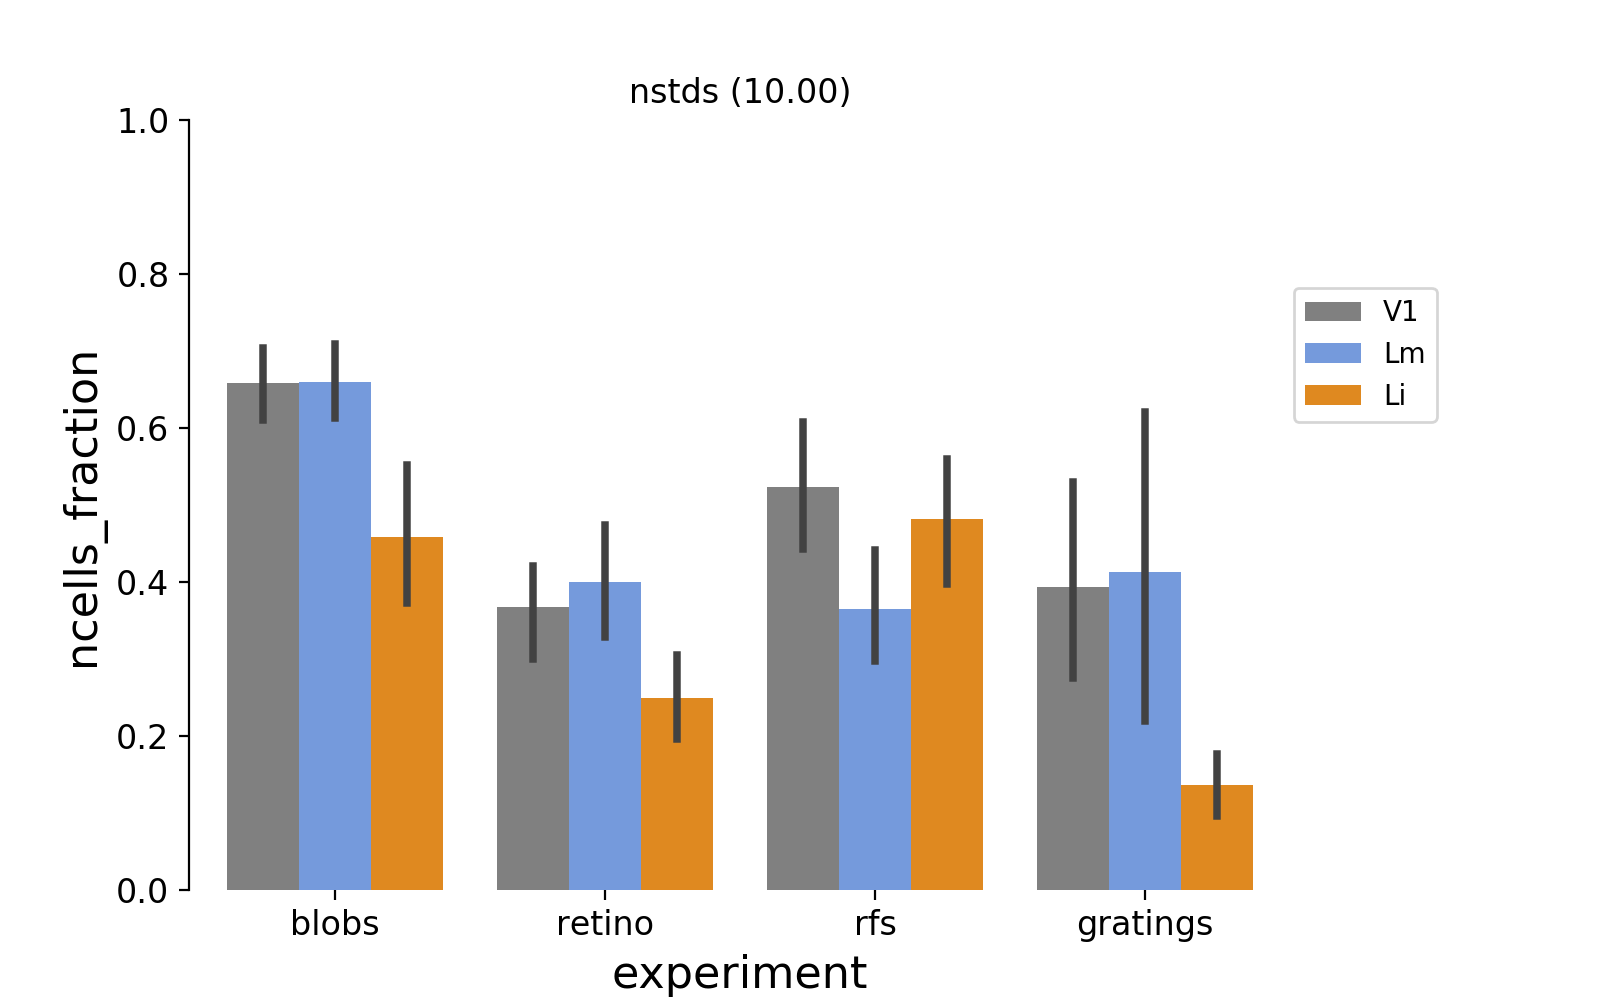

nstds-10.00_frac-responsive_by-experiment_merge-rfs


In [173]:
# ax = sns.catplot(x="experiment", y="ncells_fraction", hue='visual_area', data=newdf,
#            kind='bar', ci=95, palette='colorblind')
box = False
palette = area_colors

fig, ax = pl.subplots(figsize=(8, 5))

if box:
    sns.boxplot(x="experiment", y="ncells_fraction", hue='visual_area', data=newdf,
           palette=palette, hue_order=visual_areas, ax=ax)
else:
    sns.barplot(x="experiment", y="ncells_fraction", hue='visual_area', data=newdf,
               ci=95, palette=palette, hue_order=visual_areas, ax=ax)

# sns.swarmplot(x="experiment", y="ncells_fraction", hue='visual_area', data=newdf, ax=ax, #,
#              hue_order=visual_areas) 

#pl.ylim([0, 1])
ax.legend(bbox_to_anchor=(1.0, 0.8))
pl.title('%s (%.2f)' % (responsive_test, responsive_thr))
pl.subplots_adjust(right=0.8)
ax.set_ylim([0, 1])

sns.despine(bottom=True, offset=4, trim=True)

figname = '%s-%.2f_frac-responsive_by-experiment_merge-rfs' % (responsive_test, responsive_thr)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

print(figname)

In [111]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity/stats-traces001-corrected-dff-ROC-thr-0.05'

<IPython.core.display.Javascript object>


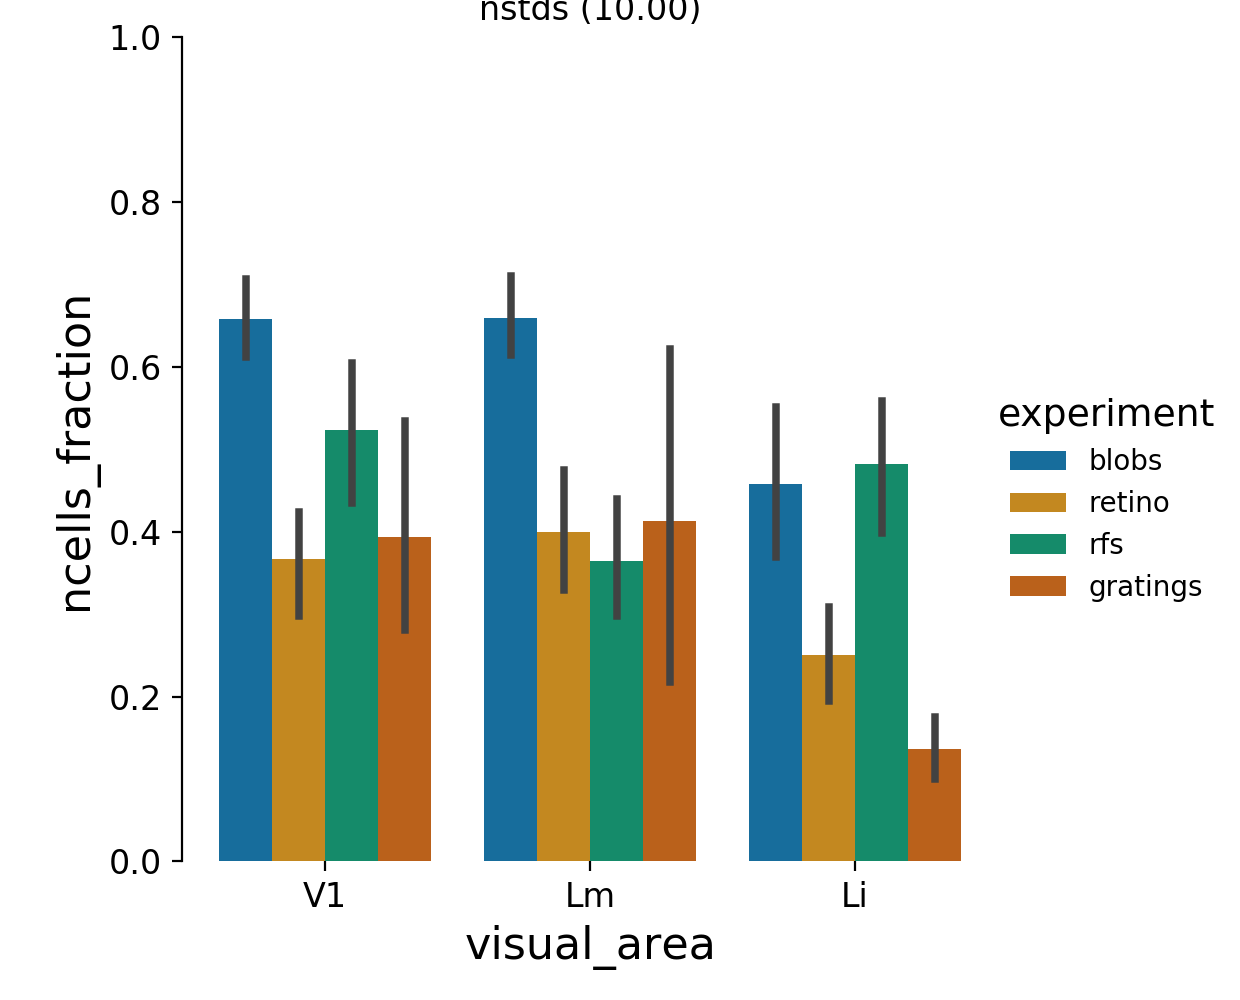

nstds-10.00_fraction-responsive_bar_merge-rfs


In [174]:
kind = 'bar'
if kind == 'box':
    gp = sns.catplot(x="visual_area", y="ncells_fraction", hue='experiment', data=newdf,
               kind='box', ci=95, palette='colorblind', whis=1.5, order=visual_areas, fliersize=5)
else:
    gp = sns.catplot(x="visual_area", y="ncells_fraction", hue='experiment', data=newdf,
               kind='bar', palette='colorblind', order=visual_areas)

#sns.swarmplot(x="visual_area", y="ncells_fraction", color="k", size=2, data=df, ax=gp.ax);
pl.ylim([0, 1])

#pl.ylim([0, 1])
sns.despine(bottom=True, offset=4, trim=True)
pl.title('%s (%.2f)' % (responsive_test, responsive_thr))

figname = '%s-%.2f_fraction-responsive_%s_merge-rfs' % (responsive_test, responsive_thr, kind)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)

<IPython.core.display.Javascript object>


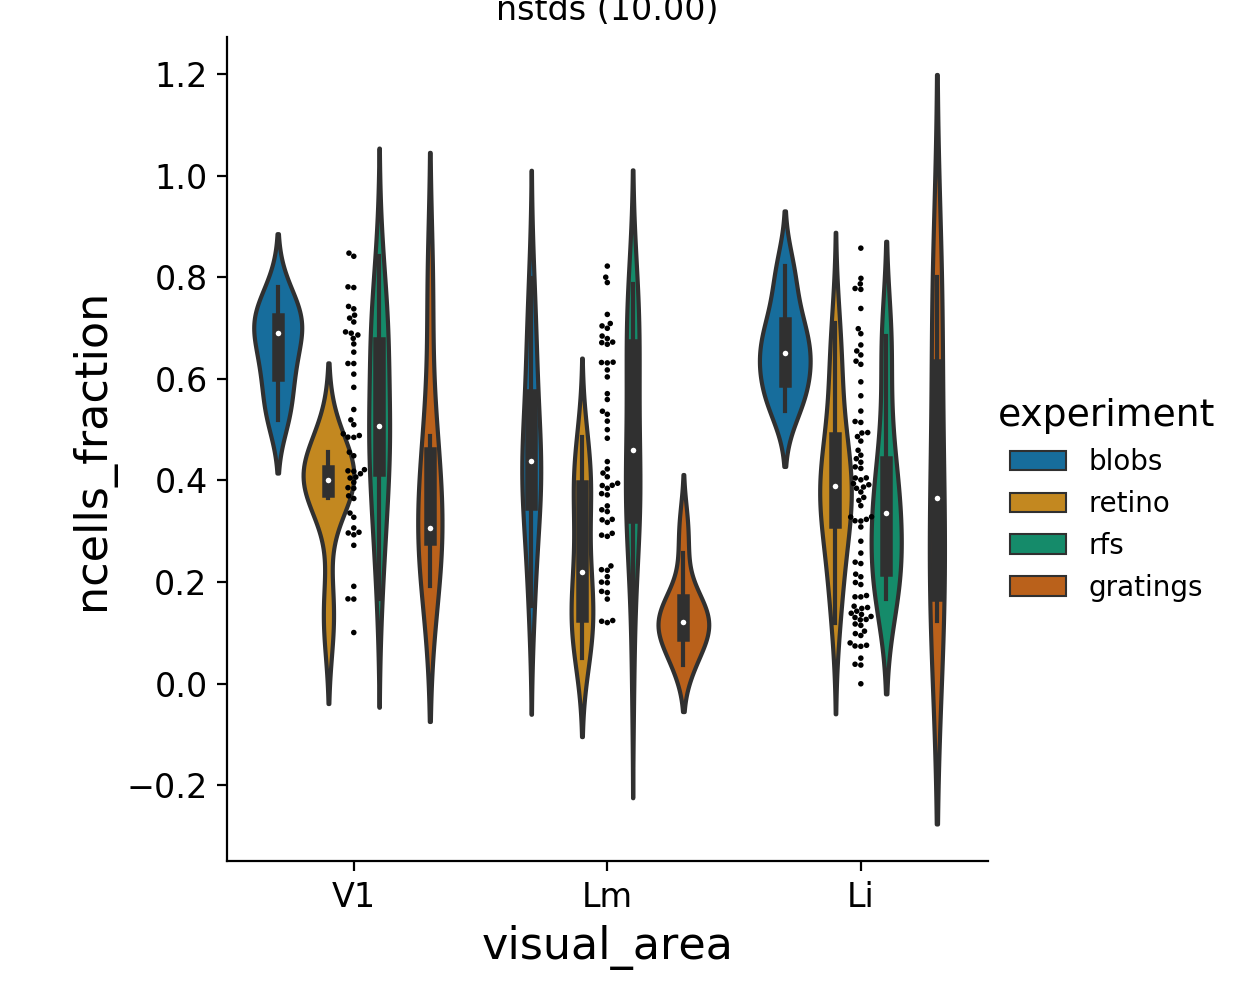

Text(0.5,1,u'nstds (10.00)')

In [175]:
gp = sns.catplot(x="visual_area", y="ncells_fraction", hue='experiment', data=newdf,
           kind='violin', palette='colorblind') #, whis=1.5)

sns.swarmplot(x="visual_area", y="ncells_fraction", color="k", size=2, data=df, ax=gp.ax);

#pl.ylim([0, 1])

pl.title('%s (%.2f)' % (responsive_test, responsive_thr))
#pl.ylim([0, 1])

pl.title('%s (%.2f)' % (responsive_test, responsive_thr))

<IPython.core.display.Javascript object>


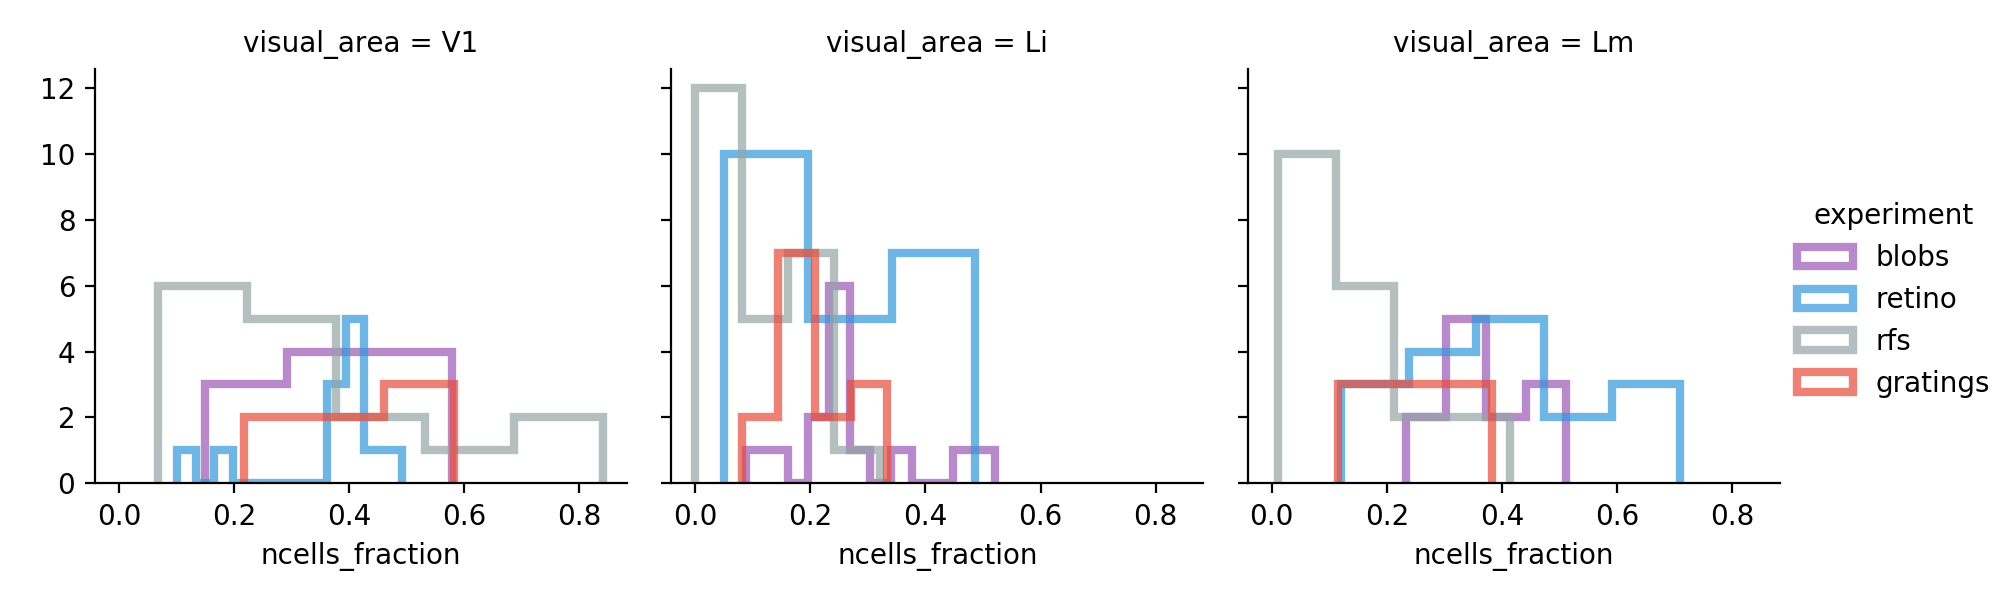

In [108]:
g = sns.FacetGrid(newdf, col='visual_area', hue='experiment')
g = g.map(sns.distplot, 'ncells_fraction', 
          kde=False,
          #hist=False, rug=True)
         hist_kws={"histtype": "step", "linewidth": 3, "alpha": 0.7})

g.add_legend()

# Compare metrics

In [176]:
min_nframes=10
n_stds=2.5
pval_responsive=0.05

nstd_desc = util.get_stats_desc(traceid=traceid, response_type=response_type,
                                responsive_test='nstds', responsive_thr=min_nframes, n_stds=n_stds)
roc_desc = util.get_stats_desc(traceid=traceid, response_type=response_type,
                                responsive_test='roc', responsive_thr=pval_responsive)

fig_id = '|'.join([optsE.fov_type, optsE.traceid, '\nstd-%s' % nstd_desc, '\nroc-%s' % roc_desc])
print fig_id


zoom2p0x|traces001|
std-stats-traces001-corrected-dff-nstds-thr-10.00|
roc-stats-traces001-corrected-dff-roc-thr-0.05


In [179]:

stds={}; rocs={}; ncells={};
for (visual_area, experiment_type, animalid, session, fov), g in sdata.groupby(['visual_area', 'experiment', 'animalid', 'session', 'fov']):
    skey = '-'.join([visual_area, animalid, session, fov])
    if skey not in stds.keys():
        stds[skey] = {}
        rocs[skey] = {}
        ncells[skey] = {}
    #%
    if experiment_type == 'gratings':
        # Initialize experiment object
        exp = util.Gratings(animalid, session, fov, traceid=traceid)
        #exp.print_info()
    elif experiment_type == 'blobs':
        exp = util.Objects(animalid, session, fov, traceid=traceid)
    else:
        continue
    
    nstd_cells, nrois_total1 = exp.get_responsive_cells(responsive_test='nstds', 
                                                        n_stds=n_stds, responsive_thr=min_nframes)
    roc_cells, nrois_total2 = exp.get_responsive_cells(responsive_test='ROC', responsive_thr=pval_responsive)
    
    assert nrois_total1 == nrois_total2, "Um wrong n cells..."
    #ncells_total = len(exp.data.info['roi_list'])
    
    stds[skey][experiment_type] = nstd_cells
    rocs[skey][experiment_type] = roc_cells
    ncells[skey][experiment_type] = nrois_total1
        

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/summary_stats/nstds/nstds_results.pkl']
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/summary_stats/ROC/roc_results.pkl']
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_

... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/summary_stats/ROC/roc_results.pkl']
... [JC120|20191111|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_603e33_traces001_b209e8_traces001_0b0a19_traces001_67c45c_traces001_8513ce_traces001_12f240/summary_stats/nstds/nstds_results.pkl']
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_603e33_traces001_b209e8_traces001_0b0a19_traces001_67c45c_traces001_8513ce_traces001_12f240/summary_stats/ROC/roc_results

... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_2f9d54_traces001_4d8870_traces001_4ea429_traces001_4161fc/summary_stats/ROC/roc_results.pkl']
... [JC117|20191105|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_9a2c63_traces001_d4de8d/summary_stats/nstds/nstds_results.pkl']
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_9a2c63_traces001_d4de8d/summary_stats/ROC/roc_results.pkl']
... [JC120|20191111|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... getting responsive cells (test: nst

... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dea723_traces001_8cef6c_traces001_abf256_traces001_fb7bfa_traces001_452942_traces001_c0afbd/summary_stats/ROC/roc_results.pkl']
... [JC091|20190627|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_99ce14_traces001_328664_traces001_f2e06a_traces001_26306f_traces001_7fd9a8_traces001_9f1071/summary_stats/nstds/nstds_results.pkl']
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_99ce14_traces001_328664_traces001_f2e06a_traces001_26306f_traces001_7fd9a8_traces001_9f1071/summary_stats/ROC/roc_results

... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_traces001_6537ce/summary_stats/nstds/nstds_results.pkl']
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_traces001_6537ce/summary_stats/ROC/roc_results.pkl']
... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_b92766_traces001_02482e_traces001_b1d533_traces001_f15eef_traces001_ccd355_traces001_b8ae95/summary_stats/nstds/nstds_

In [180]:
counts=[]
for skey in ncells.keys():
    for exp in ncells[skey].keys():
        visual_area, animalid, session, fov = skey.split('-')
        cc = pd.Series({'visual_area': visual_area,
                        'animalid': animalid,
                        'session': session,
                        'fov': fov,
                         'exp': exp,
                         'roc': len(rocs[skey][exp]),
                         'std': len(stds[skey][exp]),
                         'total': ncells[skey][exp]})
        counts.append(cc)

counts = pd.DataFrame(counts)
counts.head()           

,animalid,exp,fov,roc,session,std,total,visual_area
0,JC083,gratings,FOV1_zoom2p0x,27,20190517,29,233,Lm
1,JC083,blobs,FOV1_zoom2p0x,78,20190517,133,233,Lm
2,JC120,gratings,FOV1_zoom2p0x,34,20191111,7,190,Li
3,JC120,blobs,FOV1_zoom2p0x,46,20191111,29,190,Li
4,JC083,blobs,FOV1_zoom2p0x,96,20190507,132,182,V1


#### Compare methods

#### Compare by experiment type

<IPython.core.display.Javascript object>


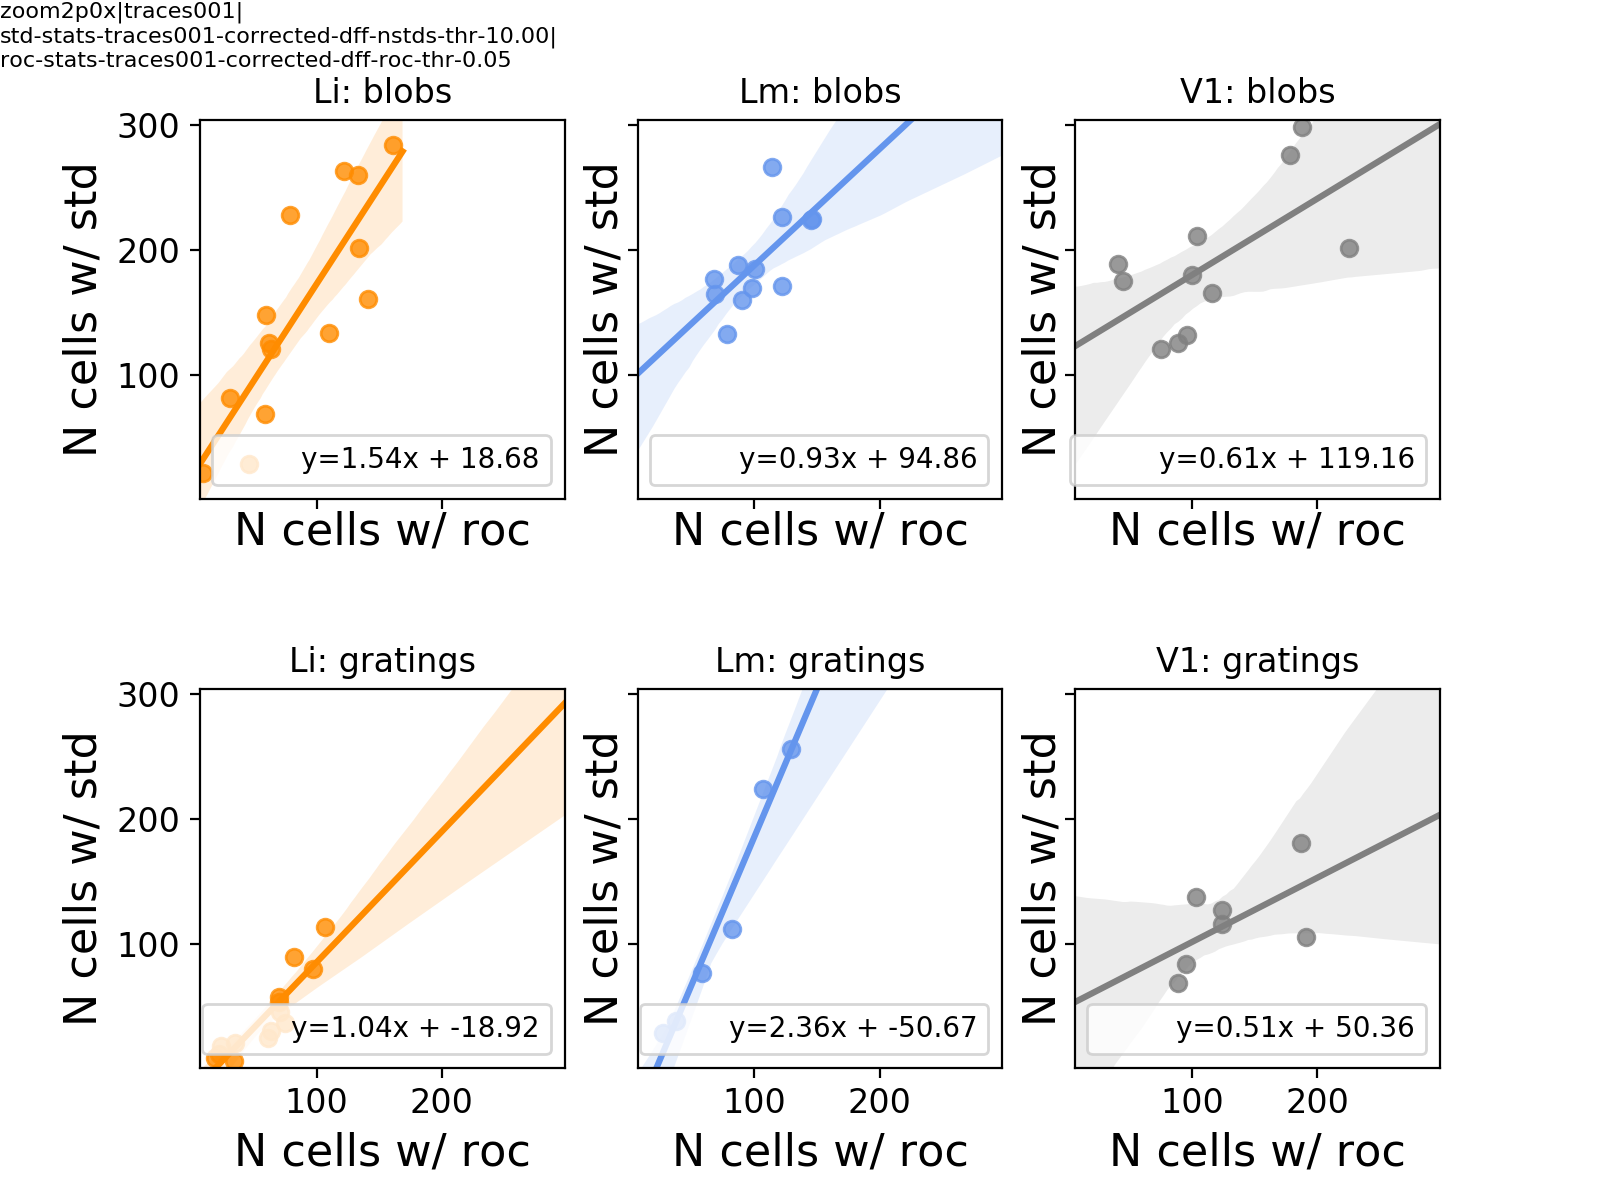

compare_ROC-vs-NSTDS_by-experiment


In [185]:

#%%
from sklearn.linear_model import LinearRegression


minv = min([counts['roc'].min(), counts['std'].min()])
maxv = max([counts['roc'].max(), counts['std'].max()])

fig, axes = pl.subplots(2,3, figsize=(8,6), sharex=True, sharey=True)
ai = 0
for (experiment, visual_area), g in counts.groupby(['exp', 'visual_area']):
    ax = axes.flat[ai]
    sns.regplot('roc', 'std', data=g, ax=ax, color=area_colors[visual_area])
    ax.set_aspect('equal')
    ax.set_xlim([minv, maxv])
    ax.set_ylim([minv, maxv])
    
    regr = LinearRegression()  # create object for the class
    xv = g['roc'].values.reshape(-1, 1)
    yv = g['std'].values.reshape(-1, 1)
    regr.fit(xv, yv)  # perform linear regression
    fitv = regr.predict(xv)  # make predictions
    ax.plot(minv, minv, alpha=0, label='y=%.2fx + %.2f' % (float(regr.coef_), float(regr.intercept_)))
    ax.legend(loc='lower right')
    ax.set_title('%s: %s' % (visual_area, experiment))
    
    ax.set_xlabel('N cells w/ roc')
    ax.set_ylabel('N cells w/ std')
    ax.set_aspect('equal')
        
    ai += 1

pl.subplots_adjust(top=0.9, hspace=0.5)

label_figure(fig, fig_id)

figname = 'compare_ROC-vs-NSTDS_by-experiment'
pl.savefig(os.path.join(aggregate_dir, 'responsivity', '%s.svg' % figname))
print(figname)
#%%

# Select dataset

In [223]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC097' #'JC059'
session = '20190617' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


experiment = 'rfs'
glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % experiment, 'traces', '%s*' % traceid,\
                      'response_stats_*', 'roistats_results.npz'))

['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_f924db_traces001_85f376_traces001_db2b5e_traces001_acfba1_traces001_c58358_traces001_205616/response_stats_20190619/roistats_results.npz']

In [227]:
fn = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % experiment, 'traces', '%s*' % traceid,\
                      'response_stats_*', 'roistats_results.npz')), key=natural_keys)[-1]

In [229]:
stats = np.load(fn)
stats

In [233]:
stats.keys()

['traceid',
 'sorted_visual',
 'responsivity_test',
 'metric',
 'animalid',
 'sorted_selective',
 'selectivity_test',
 'session',
 'selective_pval',
 'selectivity_posthoc',
 'nrois_total',
 'acquisition',
 'visual_pval']

In [231]:
stats['nrois_total']

array(438)

In [236]:
len(stats['sorted_selective'])

181

In [237]:
g

In [232]:
df[(df['animalid']==animalid) & (df['session']==session)]

,animalid,experiment,fov,session,visual_area,ncells_total,ncells_active,ncells_fraction
71,JC097,rfs,FOV1_zoom2p0x,20190617,V1,262.0,88.0,0.335878
72,JC097,gratings,FOV1_zoom2p0x,20190617,V1,438.0,84.0,0.191781
73,JC097,blobs,FOV1_zoom2p0x,20190617,V1,438.0,276.0,0.630137
74,JC097,retino,FOV1_zoom2p0x,20190617,V1,438.0,169.0,0.385845


In [276]:
df.loc[ix].values

array(['JC113', 'rfs10', 'FOV2_zoom2p0x', '20191012', 'Li', 41.0, 22.0,
       0.53658536585365857], dtype=object)

In [277]:
df.loc[ix]

animalid                   JC113
experiment                 rfs10
fov                FOV2_zoom2p0x
session                 20191012
visual_area                   Li
ncells_total                  41
ncells_active                 22
ncells_fraction         0.536585
Name: 192, dtype: object

In [377]:
for k, v in stats.items():
    if k in ['nrois_total', 'selective_pval', 'visual_pval']:
        stats[k] = float(v)
    elif k in ['sorted_visual', 'sorted_selective']:
        pass
    else:
        stats[k] = str(k)
    

In [391]:
stats
    

{'acquisition': array('FOV1_zoom2p0x',
       dtype='|S13'), 'animalid': array('JC084',
       dtype='|S5'), 'metric': array('zscore',
       dtype='|S6'), 'nrois_total': array(260), 'responsivity_test': array('RManova1',
       dtype='|S8'), 'selective_pval': 0.05, 'selectivity_posthoc': array('dunn',
       dtype='|S4'), 'selectivity_test': array('kruskal_wallis',
       dtype='|S14'), 'session': array('20190522',
       dtype='|S8'), 'sorted_selective': [93,
  155,
  91,
  231,
  69,
  68,
  57,
  59,
  150,
  17,
  177,
  151,
  233,
  148,
  163,
  236,
  178,
  258,
  144,
  97,
  232,
  215,
  75,
  19,
  237,
  123,
  77,
  175,
  33,
  60,
  81,
  245,
  79,
  128,
  63,
  228,
  9,
  38,
  78,
  76,
  188,
  21,
  119,
  193,
  165,
  106,
  152,
  159,
  229,
  135,
  26,
  234,
  67,
  105,
  212,
  70,
  187,
  56,
  1,
  216,
  124,
  116,
  168,
  117,
  71,
  147,
  14,
  243,
  217,
  27,
  61,
  140,
  164,
  122], 'sorted_visual': [93,
  258,
  78,
  259,
  17,
  155

In [274]:
tmp_ign2 = ['JC091_20191008_FOV1_zoom2p0x_rfs10',
           'JC092_20190527_FOV3_zoom2p0x_gratings',
           'JC078_20190430_FOV1_zoom2p0x_rfs']

In [428]:
visual_pval = 0.01
selective_pval = 0.01

In [429]:
ncells_selective = []
ncells_visual = []
keep_ix = []
mismatch = []

#for (visual_area, animalid, session, fov, experiment), grp in df.groupby(['visual_area', 'animalid', 'session', 'fov', 'experiment']):
for ix in df.index.tolist():
    animalid, experiment, fov, session, visual_area, nc_total, _, _ = df.loc[ix].values

    dkey = '_'.join([animalid, session, fov, experiment])
    
    if dkey in tmp_ign2:
        continue
        
    if experiment == 'retino':
        keep_ix.append(ix)
        ncells_selective.append(float(df['ncells_active'][ix]))
        ncells_visual.append(float(df['ncells_active'][ix]))
        continue
    
    if experiment == 'rfs' and int(session)<20190511:
        expname = 'gratings'
    else:
        expname = experiment
    
    # Load calculated stats
    statsfn = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % expname, 'traces', '%s*' % traceid,\
                     'response_stats_*', 'roistats_results.npz')), key=natural_keys)[-1]
    stats = np.load(statsfn)
    stats = dict(stats)
    
    if (stats['selective_pval'] != selective_pval) or (stats['visual_pval'] != visual_pval):

        # Get visual
        visual_fn = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % expname,
                                             'traces', '%s*' % traceid, 'response_stats*',
                                              'responsivity_*', '*_results.json')), key=natural_keys)[-1]
        with open(visual_fn, 'r') as f:
            vis = json.load(f)
        visual_sorted = sorted([(int(k), v['F']) for k, v in vis.items() if v['p'] < visual_pval], key=lambda x: x[1])[::-1]
        visual_pass = [int(k[0]) for k in visual_sorted]

        # Get selective
        selective_fn = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % expname,
                                             'traces', '%s*' % traceid, 'response_stats*',
                                              'selective_*', '*posthoc_dunn.npz')), key=natural_keys)[-1]
        sel = np.load(selective_fn)
        sdict = sel['arr_0'][()]
        selective_sorted = sorted([(int(k), sdict[k]['H']) for k in visual_pass if sdict[k]['p'] < selective_pval], key=lambda x: x[1])[::-1]
        selective_pass = [int(k[0]) for k in selective_sorted]

        # Update summary dict
        stats['sorted_selective'] = selective_pass
        stats['sorted_visual'] = visual_pass
        stats['selective_pval'] = selective_pval
        stats['visual_pval'] = visual_pval
        
    summary_fn = os.path.join(os.path.split(statsfn)[0], 'summary_vis-p%.2f_sel-p%.2f.json' % (visual_pval, selective_pval))
    for k, v in stats.items():
        if k in ['nrois_total', 'selective_pval', 'visual_pval']:
            stats[k] = float(v)
        elif k in ['sorted_visual', 'sorted_selective']:
            pass
        else:
            stats[k] = str(k)
        
    with open(summary_fn, 'w') as f:
        json.dump(stats, f)
    #print("Updated stats")

#     if nc_total != float(stats['nrois_total']):
#         print("Mismatch in N cells, %s (%i v %i)" % (dkey, nc_total, float(stats['nrois_total'])))
#         mismatch.append((dkey, nc_total, float(stats['nrois_total'])))
#         df['ncells_total'][ix] = float(stats['nrois_total'])

    nselective = float(len(stats['sorted_selective']))
    nvisual = float(len(stats['sorted_visual']))
    
    ncells_selective.append(nselective)
    ncells_visual.append(nvisual)
    keep_ix.append(ix)
    
    
    

In [356]:
stats.keys()

['traceid',
 'sorted_visual',
 'responsivity_test',
 'metric',
 'animalid',
 'sorted_selective',
 'selectivity_test',
 'session',
 'selective_pval',
 'selectivity_posthoc',
 'nrois_total',
 'acquisition',
 'visual_pval']

In [430]:
df.shape

(185, 8)

In [431]:
len(keep_ix)

182

In [432]:
fdf = df.loc[keep_ix].reset_index(drop=True)

In [433]:
fdf.shape

(182, 8)

In [434]:
df.head()

,animalid,experiment,fov,session,visual_area,ncells_total,ncells_active,ncells_fraction
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,260.0,111.0,0.426923
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,260.0,127.0,0.488462
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,260.0,180.0,0.692308
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,260.0,100.0,0.384615
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,238.0,42.0,0.176471


In [435]:
fdf.head()

,animalid,experiment,fov,session,visual_area,ncells_total,ncells_active,ncells_fraction
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,260.0,111.0,0.426923
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,260.0,127.0,0.488462
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,260.0,180.0,0.692308
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,260.0,100.0,0.384615
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,238.0,42.0,0.176471


In [436]:
fdf['ncells_selective'] = np.array([float(i) for i in ncells_selective])
fdf['ncells_visual'] = np.array([float(i) for i in ncells_visual])
fdf['fraction_selective'] = fdf['ncells_selective'] / fdf['ncells_total']
fdf['fraction_visual'] = fdf['ncells_visual'] / fdf['ncells_total']
fdf['fraction_selective_visual'] = fdf['ncells_selective'] / fdf['ncells_visual']


In [437]:
fdf.head()

,animalid,experiment,fov,session,visual_area,ncells_total,ncells_active,ncells_fraction,ncells_selective,ncells_visual,fraction_selective,fraction_visual,fraction_selective_visual
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,260.0,111.0,0.426923,54.0,104.0,0.207692,0.400000,0.519231
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,260.0,127.0,0.488462,180.0,231.0,0.692308,0.888462,0.779221
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,260.0,180.0,0.692308,128.0,211.0,0.492308,0.811538,0.606635
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,260.0,100.0,0.384615,100.0,100.0,0.384615,0.384615,1.000000
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,238.0,42.0,0.176471,10.0,66.0,0.042017,0.277311,0.151515


<IPython.core.display.Javascript object>


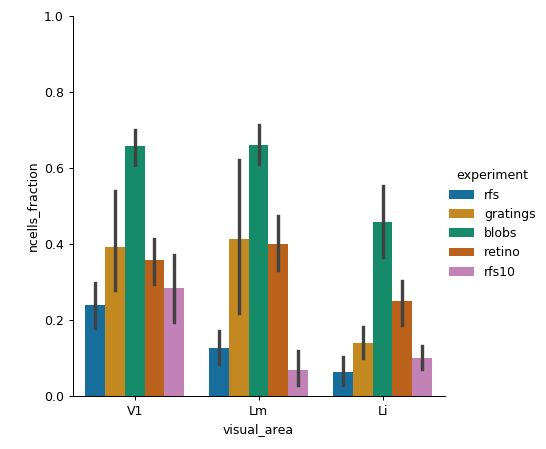

(0, 1)

In [438]:
ax = sns.catplot(x="visual_area", y="ncells_fraction", hue='experiment', data=fdf,
           kind='bar', ci=95, palette='colorblind')
pl.ylim([0, 1])

#### Look at selective

<IPython.core.display.Javascript object>


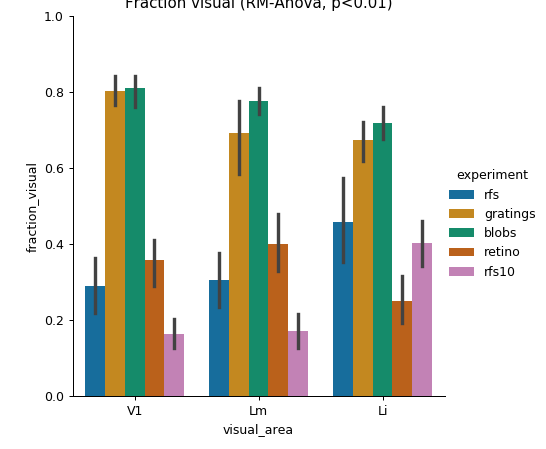

(0, 1)

In [440]:
ax = sns.catplot(x="visual_area", y="fraction_visual", hue='experiment', data=fdf,
           kind='bar', ci=95, palette='colorblind')
pl.title("Fraction visual (RM-Anova, p<%.2f)" % visual_pval)
pl.ylim([0, 1])

<IPython.core.display.Javascript object>


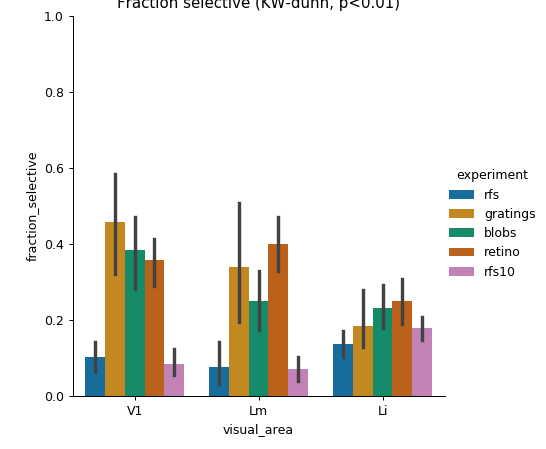

(0, 1)

In [441]:
ax = sns.catplot(x="visual_area", y="fraction_selective", hue='experiment', data=fdf,
           kind='bar', ci=95, palette='colorblind')
pl.title("Fraction selective (KW-dunn, p<%.2f)" % selective_pval)
pl.ylim([0, 1])

<IPython.core.display.Javascript object>


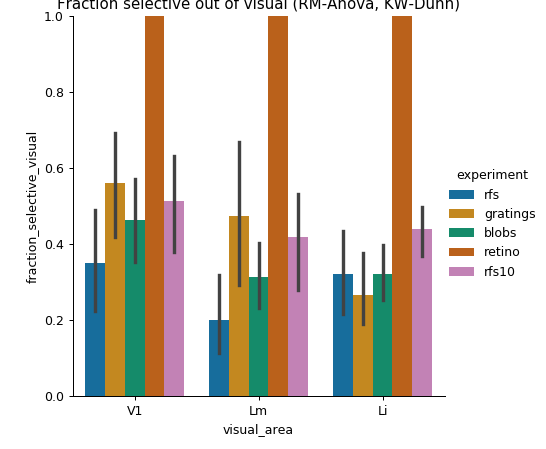

(0, 1)

In [442]:
ax = sns.catplot(x="visual_area", y="fraction_selective_visual", hue='experiment', data=fdf,
           kind='bar', ci=95, palette='colorblind')
pl.title("Fraction selective out of visual (RM-Anova, KW-Dunn)")
pl.ylim([0, 1])

In [323]:
fdf[(fdf['animalid']=='JC120') & (fdf['session']=='20191111')]

,animalid,experiment,fov,session,visual_area,ncells_total,ncells_active,ncells_fraction,ncells_selective,ncells_visual,fraction_selective,fraction_visual,fraction_selective_visual
106,JC120,rfs10,FOV1_zoom2p0x,20191111,Li,190.0,4.0,0.021053,108.0,139.0,0.568421,0.731579,0.776978
107,JC120,gratings,FOV1_zoom2p0x,20191111,Li,190.0,7.0,0.036842,132.0,165.0,0.694737,0.868421,0.800000
108,JC120,blobs,FOV1_zoom2p0x,20191111,Li,190.0,29.0,0.152632,138.0,165.0,0.726316,0.868421,0.836364
109,JC120,retino,FOV1_zoom2p0x,20191111,Li,190.0,14.0,0.073684,14.0,14.0,0.073684,0.073684,1.000000


<IPython.core.display.Javascript object>


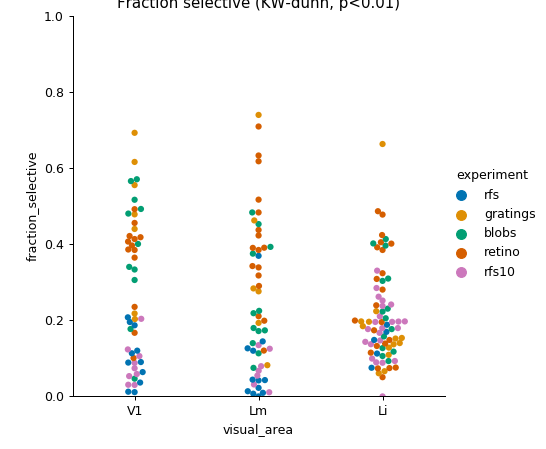

(0, 1)

In [446]:
ax = sns.catplot(x="visual_area", y="fraction_selective", hue='experiment', data=fdf,
           kind='swarm', palette='colorblind')
pl.title("Fraction selective (KW-dunn, p<%.2f)" % selective_pval)
pl.ylim([0, 1])

<IPython.core.display.Javascript object>


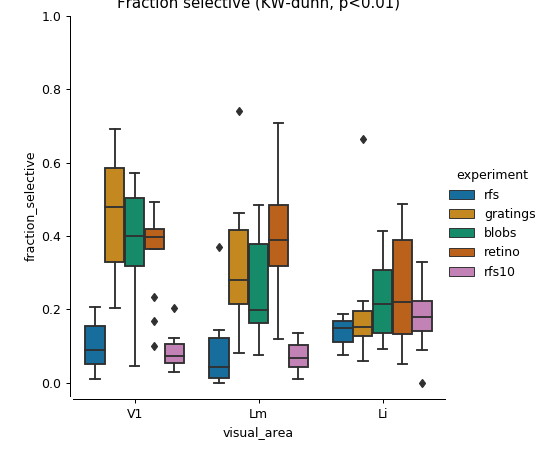

In [460]:
ax = sns.catplot(x="visual_area", y="fraction_selective", hue='experiment', data=fdf,
           kind='box', palette='colorblind')
pl.title("Fraction selective (KW-dunn, p<%.2f)" % selective_pval)
pl.ylim([pl.ylim()[0], 1])
sns.despine(offset=2) #trim=True)

In [269]:
animalid

'JC078'

In [270]:
experiment

'rfs'

In [271]:
session

'20190430'

In [272]:
fov

'FOV1_zoom2p0x'

In [273]:
expname

'gratings'

In [261]:
'JC091_20191008_FOV1_zoom2p0x_rfs10'

'JC091_20191008_FOV1_zoom2p0x_rfs10'

In [ ]:
'JC092_20190527_FOV3_zoom2p0x_gratings'

In [ ]:
'JC078_20190430_FOV1_zoom2p0x_rfs'

In [324]:
stats.keys()

['traceid',
 'sorted_visual',
 'responsivity_test',
 'metric',
 'animalid',
 'sorted_selective',
 'selectivity_test',
 'session',
 'selective_pval',
 'selectivity_posthoc',
 'nrois_total',
 'acquisition',
 'visual_pval']

In [325]:
stats['visual_pval']

array(0.5)

In [326]:
stats['selective_pval']

array(0.5)

In [327]:
selective_fn = glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % expname,
                                     'traces', '%s*' % traceid, 'response_stats*',
                                      'selective_*', '*posthoc_dunn.npz'))[-1]
selective_fn

'/n/coxfs01/2p-data/JC113/20191012/FOV2_zoom2p0x/combined_rfs10_static/traces/traces001_0cc7eb_traces001_2f7e82_traces001_4ccb5d_traces001_7aeac9_traces001_9c7cc7/response_stats_20191013/selective_KW_dunn/selectivity_KW_posthoc_dunn.npz'

In [328]:
sel = np.load(selective_fn)
sel.keys()

['arr_0']

In [335]:
visual_pval = 0.05
selective_pval = 0.01

visual_fn = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % expname,
                                     'traces', '%s*' % traceid, 'response_stats*',
                                      'responsivity_*', '*_results.json')), key=natural_keys)[-1]
with open(visual_fn, 'r') as f:
    vis = json.load(f)
visual_pass = [int(k) for k, v in vis.items() if v['p'] < 0.05]

selective_fn = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % expname,
                                     'traces', '%s*' % traceid, 'response_stats*',
                                      'selective_*', '*posthoc_dunn.npz')), key=natural_keys)[-1]
sel = np.load(selective_fn)
sdict = sel['arr_0'][()]
selective_pass = [int(k) for k in visual_pass if sdict[k]['p'] < selective_pval]


'/n/coxfs01/2p-data/JC113/20191012/FOV2_zoom2p0x/combined_rfs10_static/traces/traces001_0cc7eb_traces001_2f7e82_traces001_4ccb5d_traces001_7aeac9_traces001_9c7cc7/response_stats_20191013/responsivity_RManova1/visual_rois_RManova1_results.json'

In [332]:
sdict = sel['arr_0'][()]


In [333]:
len(sdict.keys())

236

In [365]:
sdict[0]

{'H': 228.95079141146653,
 'p': 4.0303462068176008e-20,
 'p_rank':            config001     config002  config003  config004  config005  \
 config001  -1.000000  2.789419e-02   0.256265   0.244135   0.148661   
 config002   0.027894 -1.000000e+00   0.287552   0.301109   0.450554   
 config003   0.256265  2.875522e-01  -1.000000   0.976506   0.757311   
 config004   0.244135  3.011095e-01   0.976506  -1.000000   0.779812   
 config005   0.148661  4.505535e-01   0.757311   0.779812  -1.000000   
 config006   0.534099  1.147933e-01   0.607600   0.587162   0.410783   
 config007   0.697533  7.027742e-02   0.455298   0.437713   0.291139   
 config008   0.498189  1.281523e-01   0.647009   0.625995   0.443120   
 config009   0.433074  1.571186e-01   0.725347   0.703372   0.509038   
 config010   0.213522  3.396620e-01   0.913461   0.936855   0.841214   
 config011   0.078913  6.586736e-01   0.534099   0.553642   0.754473   
 config012   0.097088  5.894493e-01   0.600367   0.621008   0.829878  

In [ ]:

visual_fn = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % expname,
                                     'traces', '%s*' % traceid, 'response_stats*',
                                      'responsivity_*', '*_results.json')), key=natural_keys)[-1]
visual_fn

In [336]:
with open(visual_fn, 'r') as f:
    vis = json.load(f)

visual_pass = [int(k) for k, v in vis.items() if v['p'] < 0.05]
selective_pass = [int(k) for k in visual_pass if sdict[k]['p'] < 0.01]



In [340]:
vis[str(0)]

{u'F': 60.83158005371948,
 u'df': 1,
 u'dim': [2],
 u'eta': 0.0038697108373295466,
 u'eta2_p': 0.04408623554720438,
 u'mse': 309.88333771786256,
 u'p': 1.2556506755744401e-14}

In [345]:
visual_pass = [int(k) for k, v in vis.items() if v['p'] < 0.05]
len(visual_pass)

150

In [342]:
len([int(k) for k, v in vis.items() if v['p'] < 0.05])


150

In [343]:
len([int(k) for k, v in vis.items() if v['p'] < 0.5])


236

<IPython.core.display.Javascript object>


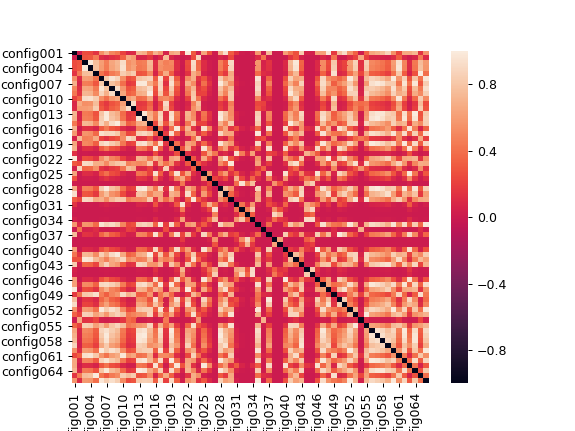

In [462]:
pl.figure()
sns.heatmap(sdict[0]['p_rank'])


In [354]:
len([k for k in visual_pass if sdict[k]['p'] < 0.01])

84

In [334]:
fdf[(fdf['animalid']=='JC113') & (fdf['session']=='20191012')]

,animalid,experiment,fov,session,visual_area,ncells_total,ncells_active,ncells_fraction,ncells_selective,ncells_visual,fraction_selective,fraction_visual,fraction_selective_visual
169,JC113,retino,FOV3_zoom2p0x,20191012,Lm,551.0,175.0,0.317604,175.0,175.0,0.317604,0.317604,1.000000
170,JC113,rfs10,FOV3_zoom2p0x,20191012,Lm,551.0,20.0,0.036298,341.0,400.0,0.618875,0.725953,0.852500
174,JC113,retino,FOV1_zoom2p0x,20191012,Li,317.0,47.0,0.148265,47.0,47.0,0.148265,0.148265,1.000000
175,JC113,rfs10,FOV1_zoom2p0x,20191012,Li,317.0,2.0,0.006309,236.0,274.0,0.744479,0.864353,0.861314
180,JC113,retino,FOV2_zoom2p0x,20191012,Li,286.0,110.0,0.384615,110.0,110.0,0.384615,0.384615,1.000000
181,JC113,rfs10,FOV2_zoom2p0x,20191012,Li,286.0,22.0,0.076923,214.0,236.0,0.748252,0.825175,0.906780
